In [80]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px

In [81]:
df = pd.read_csv("df.csv")

df.head(3)

,Unnamed: 0,Unnamed: 0.1,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat,lon,price,...,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title
0,0,0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,3430787.0,-34.661824,-58.508839,62000.0,...,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,2.0,NaN,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB
1,2,2,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,3430787.0,-34.652262,-58.522982,72000.0,...,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,2.0,NaN,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
2,3,3,PH,Liniers,|Argentina|Capital Federal|Liniers|,Capital Federal,3431333.0,-34.647797,-58.516424,95000.0,...,95000.0,NaN,NaN,1582.902780,NaN,NaN,3.0,NaN,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado


In [82]:
df.drop(["Unnamed: 0", "Unnamed: 0.1","place_with_parent_names","state_name","geonames_id",
         "price","currency","price_aprox_local_currency"
         ,"surface_total_in_m2","surface_covered_in_m2","price_aprox_usd"],
        axis=1, inplace=True)

In [83]:
df.isnull().sum()

property_type           0
place_name              0
lat                  6401
lon                  6401
price_usd_per_m2        0
price_per_m2         3576
floor               24327
rooms                5415
expenses            21168
description             0
title                   0
dtype: int64

In [84]:
df.dropna(subset=["lat","lon","price_per_m2"], inplace=True)

In [85]:
patron_monoambiente = "(?P<monoambs>[a-zA-Z]?monoamb)"
regex_monoambiente = re.compile(patron_monoambiente, re.IGNORECASE)
matches_monoambientes= df.description.apply(lambda x: x if x is np.NaN else regex_monoambiente.search(x))
matches_monoambientes_mask = matches_monoambientes.notnull()
matches_monoambientes_not_null = matches_monoambientes[matches_monoambientes_mask]
print(f"Cantidad de matches de monoambientes en columna description: {matches_monoambientes_not_null.notnull().sum()}")
matches_monoambientes_not_null

df.loc[df.rooms.isnull(),"rooms"]= matches_monoambientes_not_null.apply(lambda x: x.group("monoambs"))

patron_monoambiente = "(?P<monoambs>[a-zA-Z]?monoamb)"
regex_monoambiente = re.compile(patron_monoambiente, re.IGNORECASE)
matches_monoambientes= df.title.apply(lambda x: x if x is np.NaN else regex_monoambiente.search(x))
matches_monoambientes_mask = matches_monoambientes.notnull()
matches_monoambientes_not_null = matches_monoambientes[matches_monoambientes_mask]
print(f"Cantidad de matches de monoambientes en columna title: {matches_monoambientes_not_null.notnull().sum()}")


df.loc[df.rooms.isnull(),"rooms"]= matches_monoambientes_not_null.apply(lambda x: x.group("monoambs"))
df.rooms.isnull().sum()

Cantidad de matches de monoambientes en columna description: 2199
Cantidad de matches de monoambientes en columna title: 1379


2080

In [86]:
df.rooms.unique()
df.rooms.replace(["MONOAMB","monoamb","Monoamb","oMonoamb","MonoAmb","aMonoamb","OMonoamb","LMonoamb","nMonoamb"],1, inplace=True)
df.rooms.unique()

array([ 2.,  1., nan,  4.,  3.,  5.,  6.,  7., 17., 22., 10.,  9.,  8.,
       15., 12., 11., 14., 51.,  0., 50., 72., 60.])

In [87]:
patron_monoambiente = "(?P<ambientes>uno|dos|tres|cuatro|cinco|seis)\s?(ambiente|ambientes|dorm|dormitorios)\.?"
regex_monoambiente = re.compile(patron_monoambiente, re.IGNORECASE)
matches_monoambientes= df.description.apply(lambda x: x if x is np.NaN else regex_monoambiente.search(x))
matches_monoambientes_mask = matches_monoambientes.notnull()
matches_monoambientes_not_null = matches_monoambientes[matches_monoambientes_mask]
print(f"Cantidad de matches de monoambientes en columna title: {matches_monoambientes_not_null.notnull().sum()}")
matches_monoambientes_not_null




df.loc[df.rooms.isnull(),"rooms"]= matches_monoambientes_not_null.apply(lambda x: x.group("ambientes"))

df.rooms.isnull().sum()

Cantidad de matches de monoambientes en columna title: 2728


1692

In [88]:
df.rooms.unique()
df.rooms.replace(["DOS","dos","Dos","cuatro","tres","Tres","TRES","Cuatro","CINCO","cinco"],[2,2,2,4,3,3,3,4,5,5], inplace=True)

In [89]:
df.rooms = pd.to_numeric(df.rooms)
df.rooms.unique()


array([ 2.,  1.,  4.,  3., nan,  5.,  6.,  7., 17., 22., 10.,  9.,  8.,
       15., 12., 11., 14., 51.,  0., 50., 72., 60.])

In [90]:
def outliers(df, feature):
    Q1= df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

In [91]:
for x in ["house","apartment","PH","store"]:
    upper, lower = outliers(df[df.property_type==x], "rooms")
    print(x.title() ,"Upper", upper)
    print(x.title() ,"Lower", lower)
    l = df[(df.property_type==x) & ((df["rooms"] < lower) | (df['rooms'] > upper))].index
    df.drop(l, inplace=True)
    print(df[(df.property_type==x)].rooms.describe())
    print("--"*20)


House Upper 8.0
House Lower 0.0
count    938.000000
mean       4.219616
std        1.424275
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        8.000000
Name: rooms, dtype: float64
----------------------------------------
Apartment Upper 4.5
Apartment Lower 0.5
count    13828.000000
mean         2.355655
std          1.055243
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: rooms, dtype: float64
----------------------------------------
Ph Upper 5.5
Ph Lower 1.5
count    1188.000000
mean        3.355219
std         0.938773
min         2.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: rooms, dtype: float64
----------------------------------------
Store Upper 6.0
Store Lower -2.0
count    78.000000
mean      2.089744
std       1.443174
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max       6.000000
Name: 

In [92]:
for x in ["house","apartment","PH","store"]:
    upper, lower = outliers(df[df.property_type==x], "price_usd_per_m2")
    print(x.title() ,"Upper", upper)
    print(x.title() ,"Lower", lower)
    l = df[(df.property_type==x) & ((df["price_usd_per_m2"] < lower) | (df['price_usd_per_m2'] > upper))].index
    df.drop(l, inplace=True)
    print(df[(df.property_type==x)].rooms.describe())
    print("--"*20)

House Upper 3221.6263748312067
House Lower -150.2398721431582
count    938.000000
mean       4.219616
std        1.424275
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        8.000000
Name: rooms, dtype: float64
----------------------------------------
Apartment Upper 4070.8262471655325
Apartment Lower 807.5042517006805
count    13697.000000
mean         2.354165
std          1.055587
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: rooms, dtype: float64
----------------------------------------
Ph Upper 3374.0594287469294
Ph Lower 73.53731572481502
count    1188.000000
mean        3.355219
std         0.938773
min         2.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: rooms, dtype: float64
----------------------------------------
Store Upper 5999.760058353809
Store Lower -1346.4469441031945
count    77.000000
mean      2.051948
std

In [93]:
df_grouped = df.groupby("property_type")
df_grouped.rooms.median()

property_type
PH           3.0
apartment    2.0
house        4.0
store        1.0
Name: rooms, dtype: float64

In [94]:
df.rooms = df_grouped["rooms"].transform(lambda x: x.fillna(x.median()))

In [95]:
df1= df.copy()

In [96]:
df.drop(["floor","expenses","price_per_m2","description","title"], axis=1, inplace=True)

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.tools import eval_measures


In [98]:
df.columns

Index(['property_type', 'place_name', 'lat', 'lon', 'price_usd_per_m2',
       'rooms'],
      dtype='object')

[Text(0.5, 0, 'Longitud')]

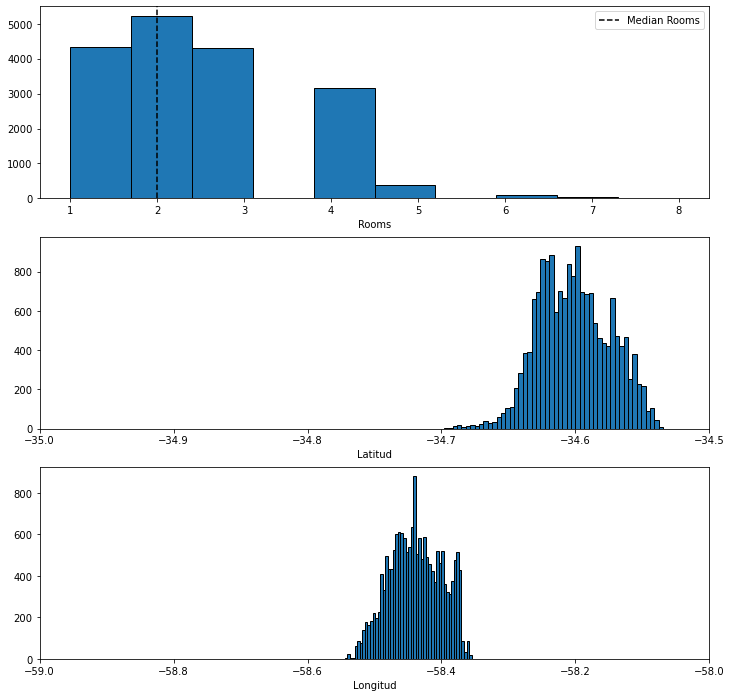

In [99]:
fig, ax = plt.subplots(3,1,figsize = (12, 12))


ax[0].hist(df.rooms, edgecolor="black");
ax[0].axvline(df.rooms.median(), color="black", ls="--", label="Median Rooms")
ax[0].legend()
ax[0].set(xlabel="Rooms")

ax[1].hist(df.lat,edgecolor="black", bins=50)
ax[1].set_xlim(-35, -34.5)
ax[1].set(xlabel="Latitud")


ax[2].hist(df.lon, edgecolor="black", bins=50)
ax[2].set_xlim(-59,-58)
ax[2].set(xlabel="Longitud")

In [100]:
#X_numericas= df[["rooms","lat","lon"]]

#scaler = StandardScaler()
#X_std = scaler.fit_transform(X_numericas)

#df_std = pd.DataFrame(X_std)
#df_std.columns=[i + "_std" for i in X_numericas.columns]
#df_std

In [101]:
#df_norm = pd.concat([df.reset_index(drop=True),df_std.reset_index(drop=True)],axis=1)
#df_norm.drop(["lat","lon","rooms"],axis=1, inplace=True)


In [102]:
dummies_property_type= pd.get_dummies(df.property_type, drop_first=True)
#print(dummies_property_type.shape)
dummies_place_name = pd.get_dummies(df.place_name, drop_first=True)
#print(dummies_place_name.shape)
df = pd.concat([df,dummies_property_type,dummies_place_name],axis=1)
df = df.drop(["property_type","place_name"],axis=1)

AL OBSERVAR QUE LOS DATOS NO CAMBIAN VOY A NORMALIZAR DESDE UN PRINCIPIO LAS FEATURES DE X_TRAIN Y X_TEST Y LA VARIABLE TARGET 


In [141]:
from sklearn.preprocessing import MinMaxScaler
y=df.price_usd_per_m2
X= df.drop(["price_usd_per_m2"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler = MinMaxScaler()

columnas = ["lat","lon","rooms"]
for columna in columnas:
    X_train[[columna]] = scaler.fit_transform(X_train[[columna]])
    X_test[[columna]] = scaler.transform(X_test[[columna]])

#CON LA TRAIN
#y_train = np.array(y_train)
#y_train= y_train.reshape(-1,1)
#y_train=scaler.fit_transform(y_train)
#CON LA TEST
#y_test = np.array(y_test)
#y_test= y_test.reshape(-1,1)
#y_test=scaler.fit_transform(y_test)


C:\Users\orest\AppData\Local\Temp\ipykernel_10344\4275826904.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[[columna]] = scaler.fit_transform(X_train[[columna]])
C:\Users\orest\anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\orest\AppData\Local\Temp\ipykernel_10344\4275826904.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

No handles with labels found to put in legend.


[Text(0.5, 0, 'Longitud')]

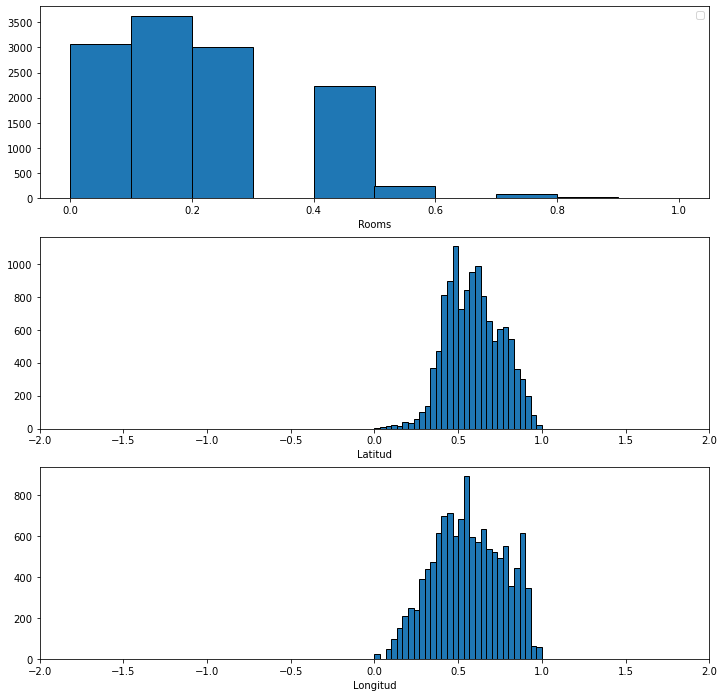

In [142]:
fig, ax = plt.subplots(3,1,figsize = (12, 12))


ax[0].hist(X_train.rooms, edgecolor="black");
ax[0].legend()
ax[0].set(xlabel="Rooms")

ax[1].hist(X_train.lat,edgecolor="black", bins=30)
ax[1].set_xlim(-2, 2)
ax[1].set(xlabel="Latitud")


ax[2].hist(X_train.lon, edgecolor="black", bins=30)
ax[2].set_xlim(-2, 2)
ax[2].set(xlabel="Longitud")

In [105]:
#dummies_property_type= pd.get_dummies(df.property_type, drop_first=True)
#print(dummies_property_type.shape)
#dummies_place_name = pd.get_dummies(df.place_name, drop_first=True)
#print(dummies_place_name.shape)


CREO UNA FUNCION PARA EVALUAR LOS DISTINTOS MODELOS

In [143]:
def evaluacion_modelos(model, Xtrain, Xtest, ytrain, ytest):
    ypred_train = model.predict(Xtrain)
    ypred_test = model.predict(Xtest)
    
    n = len(ypred_train)
    p=X_train.shape[1]

    r2 = metrics.r2_score(y_train, ypred_train)
    r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))
    print("Para los datos de train:\n")
    print("R2 Ajustado:" ,r2_ajustado)
    print("R2: ", metrics.r2_score(y_train, ypred_train))
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_train, ypred_train))
    print('Mean Squared Error (MSE): ', metrics.mean_squared_error(y_train, ypred_train))
    print(f'Root Mean Squared Error (RMSE): {np.sqrt(metrics.mean_squared_error(y_train, ypred_train))} \n')
    

    
    
    n = len(ypred_train)
    p=X_train.shape[1]
    r2 = metrics.r2_score(y_test, ypred_test)
    r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))
    print("Para los datos de test:\n")
    print("R2 Ajustado:" ,r2_ajustado)
    print("R2: ", metrics.r2_score(y_test, ypred_test))
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, ypred_test))
    print('Mean Squared Error (MSE): ', metrics.mean_squared_error(y_test, ypred_test))
    print(f'Root Mean Squared Error (RMSE): {np.sqrt(metrics.mean_squared_error(y_test, ypred_test))} \n')

    
    
    
    
    fig= plt.figure(figsize=(15,5))
    ax= plt.subplot(1,2,1)
    ax.plot(y, y, 'k-', alpha=0.75, zorder=0,linewidth= 3, label="Pendiente = 1")
    sns.regplot(x=y_test, y=ypred_test, ci=None, color="r", label="Linea predicha",)
   
    plt.title('Predicción vs. Real')
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    plt.legend()
    
    plt.subplot(1,2,2)
    sns.regplot(x=y_test, y=ypred_test, ci=None, color="r", label="Linea predicha",)
    sns.regplot(x=y_train, y=ypred_train, ci=None, label="Linea Testeo", marker="x")
    plt.title('Predicción vs. Real vs Train')
    plt.xlabel('y (test) & y(train)')
    plt.ylabel('y_pred (test & train)')
    plt.legend()

In [107]:
def stats_model_(df,feature_cols):
    print(f"Las features son: {feature_cols}")
    print(f"Tengo {len(feature_cols)} features\n")
    X = df[feature_cols]
    y= df.price_usd_per_m2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    y_pred_train= model.predict(X_train)
    
    
    
    print(f"Modelo para el Train: ")
    
    n = len(y_train)
    p = len(feature_cols)
    r2 = metrics.r2_score(y_train, y_pred_train)
    r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))
    #if len(feature_cols) >1 : 
    #    print("R2 Ajustado: ", r2_ajustado)
    print(f"RMSE: {eval_measures.rmse(y_train, y_pred_train)}")
    #print(F"R2 : {metrics.r2_score(y_train, y_pred_train)}")
    print(model.summary())
    print(f"\n")
    
    
    
    print(f"Modelo para el test: ")
    X_test = sm.add_constant(X_test)
    y_pred_test = model.predict(X_test)
    
    r2 = metrics.r2_score(y_test, y_pred_test)
    r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))
    #if len(feature_cols) >1 : 
    #    print("R2 Ajustado: ", r2_ajustado)
    print(f"RMSE: {eval_measures.rmse(y_test, y_pred_test)}")
    #print(F"R2: {metrics.r2_score(y_test, y_pred_test)}")
    print(model.summary())
    print("\n")
    
    
    
    print(f"Modelo sacando pvalues > 0.025: \n")
    
    dfa = pd.DataFrame(model.pvalues).reset_index()
    dfa = dfa.rename(columns={"index": "coeficientes",0:"pvalue"})
    coef = (dfa[dfa.pvalue > 0.025].coeficientes)
    coef = coef.values
    coef= coef.tolist()
    coef
    columnas = X.drop(coef,axis=1).columns
    print(f"Las features que quedan son: {columnas}\n")
    print(f"Tengo ahora: {len(feature_cols) - len(columnas)}\n")
    X_sin_pvalues_altos= df[columnas]
    X_train, X_test, y_train, y_test = train_test_split(X_sin_pvalues_altos, y, test_size = 0.3, random_state = 42)
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    y_pred_train= model.predict(X_train)
    print(f"Modelo para el Train: ")
    n = len(y_train)
    p = len(columnas)
    r2 = metrics.r2_score(y_train, y_pred_train)
    r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))
    #if len(columnas) >1 : 
    #    print("R2 Ajustado: ", r2_ajustado)
    print(f"RMSE: {eval_measures.rmse(y_train, y_pred_train)}")
    #print(F"R2: {metrics.r2_score(y_train, y_pred_train)}")
    print(model.summary())
    print(f"\n")
    
    
    print(f"Modelo para el test: ")
    X_test = sm.add_constant(X_test)
    y_pred_test = model.predict(X_test)
    r2 = metrics.r2_score(y_test, y_pred_test)
    r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))
    #if len(columnas) >1 : 
    #    print("R2 Ajustado: ", r2_ajustado)
    #print(f"RMSE: {eval_measures.rmse(y_test, y_pred_test)}")
    print(F"R2: {metrics.r2_score(y_test, y_pred_test)}")
    print(model.summary())

    
    
    

VOY A CONCATENAR LOS DUMMIES CON EL DF 

In [108]:
#data = pd.concat([df,dummies_property_type,dummies_place_name], axis=1)
#data.drop(["property_type","place_name"],axis=1, inplace=True)

# REGRESION LINEAL MULTIPLE SIN NORMALIZACION

In [109]:
#X= data.drop(["price_usd_per_m2"],axis=1)
#y= data.price_usd_per_m2
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


Para los datos de train:

R2 Ajustado: 0.42116411904070417
R2:  0.4242693103065184
Mean Absolute Error (MAE): 399.54870459746104
Mean Squared Error (MSE):  280883.53006880527
Root Mean Squared Error (RMSE): 529.9844621013009 

Para los datos de test:

R2 Ajustado: 0.4180629838146761
R2:  0.42118481126068363
Mean Absolute Error (MAE): 401.7369988023331
Mean Squared Error (MSE):  287003.8640034169
Root Mean Squared Error (RMSE): 535.7274157660936 



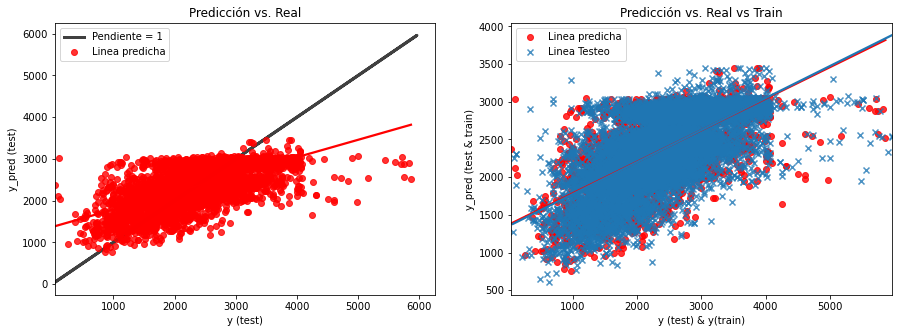

In [144]:
lr = linear_model.LinearRegression()
modelo_lr = lr.fit(X_train,y_train)
evaluacion_modelos(modelo_lr,X_train, X_test, y_train, y_test)

In [111]:
#OBSERVAMOS A CONTINUACION QUE HAY VALORES CON P VALUE ALTOS POR LO QUE SI PROPUSIERAMOS UNA HIPOTESIS NULA 
#DONDE B0=B1=B2=B3...=0, NO SE PODRIA RECHAZAR ESTA HIPOTESIS SIENDO EL P VALUE MAYOR A 0.025

In [112]:
#stats_model_(data,data.drop(["price_usd_per_m2"],axis=1).columns)

VAMOS A OBSERVAR COMO ACTUA EL MODELO DE REGRESION LINEAL MULTIPLE CON TODAS LAS FEATURES

# REGRESION LINEAL CON NORMALIZACION

In [113]:
#df_dummies_norm = pd.concat([df_norm.reset_index(drop=True),dummies_property_type.reset_index(drop=True),dummies_place_name.reset_index(drop=True)], axis=1)
#df_dummies_norm.drop(["property_type","place_name"],axis=1, inplace=True)

In [114]:
#OBSERVAMOS QUE LOS VALORES DE R2 Y DE LOS ERRORES SE MANTIENEN PRACTICAMENTE IGUALES POR ENDE NO TIENE SENTIDO NORMALIZARLOS
#PARA APLICAR LA REGRESION LINEAL SIMPLE Y MULTIPLE.

In [115]:
#X= df_dummies_norm.drop(["price_usd_per_m2"],axis=1)
#y= df_dummies_norm.price_usd_per_m2
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Para los datos de train:

R2 Ajustado: 0.42116411904070417
R2:  0.4242693103065184
Mean Absolute Error (MAE): 399.54870459746104
Mean Squared Error (MSE):  280883.53006880527
Root Mean Squared Error (RMSE): 529.9844621013009 

Para los datos de test:

R2 Ajustado: 0.4180629838146761
R2:  0.42118481126068363
Mean Absolute Error (MAE): 401.7369988023331
Mean Squared Error (MSE):  287003.8640034169
Root Mean Squared Error (RMSE): 535.7274157660936 



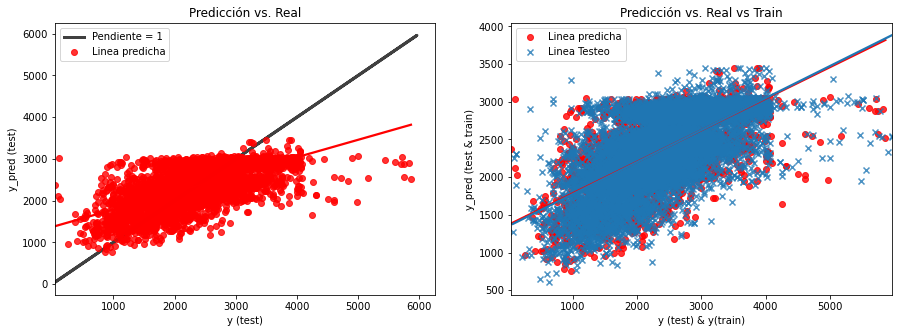

In [145]:
lr = linear_model.LinearRegression()
modelo_lrm = lr.fit(X_train,y_train)
evaluacion_modelos(modelo_lrm,X_train, X_test, y_train, y_test)

#  LASSO

In [117]:
from sklearn.model_selection import KFold
cv= KFold(5, shuffle=True, random_state=42)

In [118]:
def evaluacion_modelos(model, Xtrain, Xtest, ytrain, ytest):
    ypred_train = model.predict(Xtrain)
    ypred_test = model.predict(Xtest)
    
    n = len(ypred_train)
    p=X_train.shape[1]

    r2 = metrics.r2_score(y_train, ypred_train)
    r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))
    print("Para los datos de train:\n")
    print("R2 Ajustado:" ,r2_ajustado)
    print("R2: ", metrics.r2_score(y_train, ypred_train))
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_train, ypred_train))
    print('Mean Squared Error (MSE): ', metrics.mean_squared_error(y_train, ypred_train))
    print(f'Root Mean Squared Error (RMSE): {np.sqrt(metrics.mean_squared_error(y_train, ypred_train))} \n')

    
    
    n = len(ypred_train)
    p=X_train.shape[1]
    r2 = metrics.r2_score(y_test, ypred_test)
    r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))
    print("Para los datos de test:\n")
    print("R2 Ajustado:" ,r2_ajustado)
    print("R2: ", metrics.r2_score(y_test, ypred_test))
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, ypred_test))
    print('Mean Squared Error (MSE): ', metrics.mean_squared_error(y_test, ypred_test))
    print(f'Root Mean Squared Error (RMSE): {np.sqrt(metrics.mean_squared_error(y_test, ypred_test))} \n')

    
    
    
    
    fig= plt.figure(figsize=(15,5))
    ax= plt.subplot(1,2,1)
    ax.plot(y, y, 'k-', alpha=0.75, zorder=0,linewidth= 3, label="Pendiente = 1")
    sns.regplot(x=y_test, y=ypred_test, ci=None, color="r", label="Linea predicha",)
   
    plt.title('Predicción vs. Real')
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    plt.legend()
    
    plt.subplot(1,2,2)
    sns.regplot(x=y_test, y=ypred_test, ci=None, color="r", label="Linea predicha",)
    sns.regplot(x=y_train, y=ypred_train, ci=None, label="Linea Testeo", marker="x")
    plt.title('Predicción vs. Real vs Train')
    plt.xlabel('y (test) & y(train)')
    plt.ylabel('y_pred (test & train)')
    plt.legend()

Para los datos de train:

R2 Ajustado: 0.3280155529168838
R2:  0.3316204438790462
Mean Absolute Error (MAE): 0.20070743700805843
Mean Squared Error (MSE):  0.07616358767197898
Root Mean Squared Error (RMSE): 0.2759775129824511 

Para los datos de test:

R2 Ajustado: 0.32466733562306227
R2:  0.3282901882483469
Mean Absolute Error (MAE): 0.2019255247597751
Mean Squared Error (MSE):  0.079910923421444
Root Mean Squared Error (RMSE): 0.28268520198525426 

ALPHA: 0.01


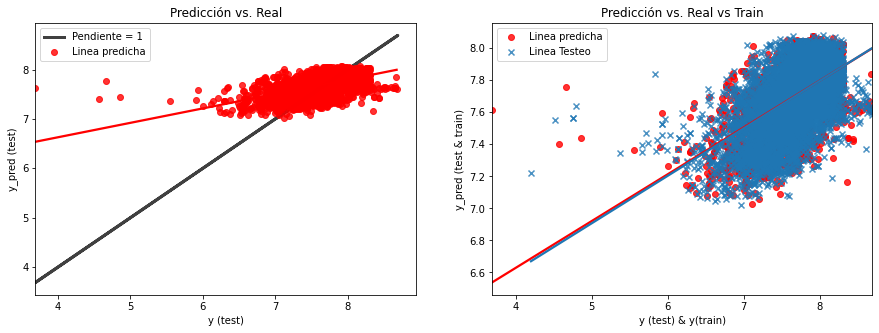

In [119]:
lr_lasso = linear_model.LassoCV(alphas = np.linspace(0.01,1,1000), normalize=False, cv=5)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
modelo_lassoCV = lr_lasso.fit(X_train, y_train)
evaluacion_modelos(modelo_lassoCV,X_train, X_test,y_train, y_test)
print(f"ALPHA: {modelo_lassoCV.alpha_}")

Para los datos de train:

R2 Ajustado: 0.3280155529168838
R2:  0.3316204438790462
Mean Absolute Error (MAE): 0.20070743700805843
Mean Squared Error (MSE):  0.07616358767197898
Root Mean Squared Error (RMSE): 0.2759775129824511 

Para los datos de test:

R2 Ajustado: 0.32466733562306227
R2:  0.3282901882483469
Mean Absolute Error (MAE): 0.2019255247597751
Mean Squared Error (MSE):  0.079910923421444
Root Mean Squared Error (RMSE): 0.28268520198525426 

ALPHA: 0.01
Coeficientes llevados a 0: 61


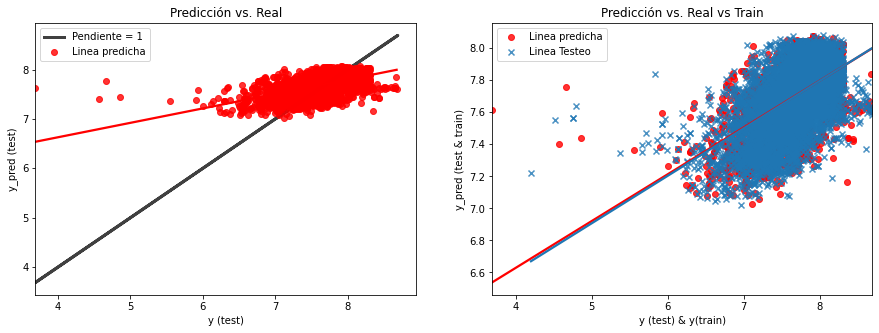

In [120]:
lasso = linear_model.Lasso(alpha=modelo_lassoCV.alpha_)
modelo_lasso = lr_lasso.fit(X_train, y_train)
evaluacion_modelos(modelo_lasso,X_train, X_test,y_train, y_test)
print(f"ALPHA: {modelo_lassoCV.alpha_}")
zero_coefs=(modelo_lasso.coef_ == 0).sum()
print(f"Coeficientes llevados a 0: {zero_coefs}")

In [121]:
#VEMOS COMO DISMINUYEN LOS COEFICIENTES

In [122]:
modelo_lassoCV.coef_ , modelo_lrm.coef_

(array([ 0.12850132,  0.0191242 , -0.03870569,  0.20232433, -0.        ,
         0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        ,  0.        , -0.        , -0.        ,  0.01293912,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.        , -0.        ,  0.        ,
         0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        ,  0.        ,  0.        ,
         0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        -0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ]),
 array([ 7.07290274e-02,  4.

# RIDGE

In [123]:
from sklearn.model_selection import cross_val_score

Para los datos de train:

R2 Ajustado: 0.4357005843247441
R2:  0.43872779406501605
Mean Absolute Error (MAE): 0.18195461719177425
Mean Squared Error (MSE):  0.06395842672488651
Root Mean Squared Error (RMSE): 0.2529000330662029 

Para los datos de test:

R2 Ajustado: 0.4182222509520993
R2:  0.42134322400234403
Mean Absolute Error (MAE): 0.18377480380759517
Mean Squared Error (MSE):  0.06884073524765595
Root Mean Squared Error (RMSE): 0.26237518031943485 

Alpha: 0.2


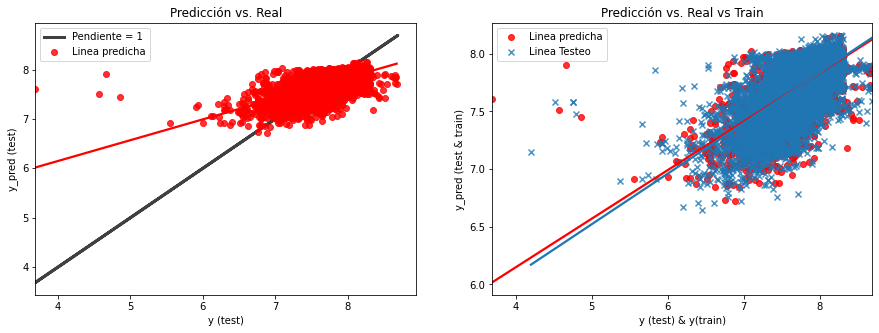

In [124]:
reg_ridge = linear_model.RidgeCV(alphas =np.linspace(0.17,0.2,100),normalize=False, cv=10)
modelo_ridgeCV = reg_ridge.fit(X_train,y_train)
evaluacion_modelos(modelo_ridgeCV,X_train,X_test,y_train,y_test)
print(f"Alpha: {modelo_ridgeCV.alpha_}")


OBSERVAMOS QUE RIDGE ME DISMINUYO MAS A LOS COEFICIENTES

In [125]:
modelo_ridgeCV.coef_.sum() - modelo_lasso.coef_.sum()

3.5618628738854636

# VOY A INCLUIR AMENITIES EN MODELAJES

In [126]:
df1.head(3)

,property_type,place_name,lat,lon,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title
0,PH,Mataderos,-34.661824,-58.508839,1127.272727,1550.000000,NaN,2.0,NaN,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB
1,apartment,Mataderos,-34.652262,-58.522982,1309.090909,1309.090909,NaN,2.0,NaN,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
3,apartment,Belgrano,-34.559873,-58.443362,3066.666667,3450.000000,NaN,1.0,NaN,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...


In [127]:
lista_atributos=['jardin','cochera','seguridad',"parrilla",'pileta','terraza','subte','lavadero',"quincho", "balcon", "gimnasio"]
for i in lista_atributos:
    atributos=i
    regex_atributo= re.compile(atributos,re.IGNORECASE )
    matches_atributos = df1.description.apply(lambda x: x if x is np.NaN else regex_atributo.search(x))
    print(i , matches_atributos.notnull().sum())
    df1[i]= matches_atributos.notnull()

jardin 440
cochera 5608
seguridad 1982
parrilla 4435
pileta 1327
terraza 4638
subte 4072
lavadero 5065
quincho 727
balcon 8627
gimnasio 1060


In [128]:
df1.columns

Index(['property_type', 'place_name', 'lat', 'lon', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms', 'expenses', 'description', 'title',
       'jardin', 'cochera', 'seguridad', 'parrilla', 'pileta', 'terraza',
       'subte', 'lavadero', 'quincho', 'balcon', 'gimnasio'],
      dtype='object')

In [129]:
df_corr = df1.drop(['property_type', 'place_name',
          'lat', 'lon','expenses','rooms',"price_per_m2" ],axis=1)

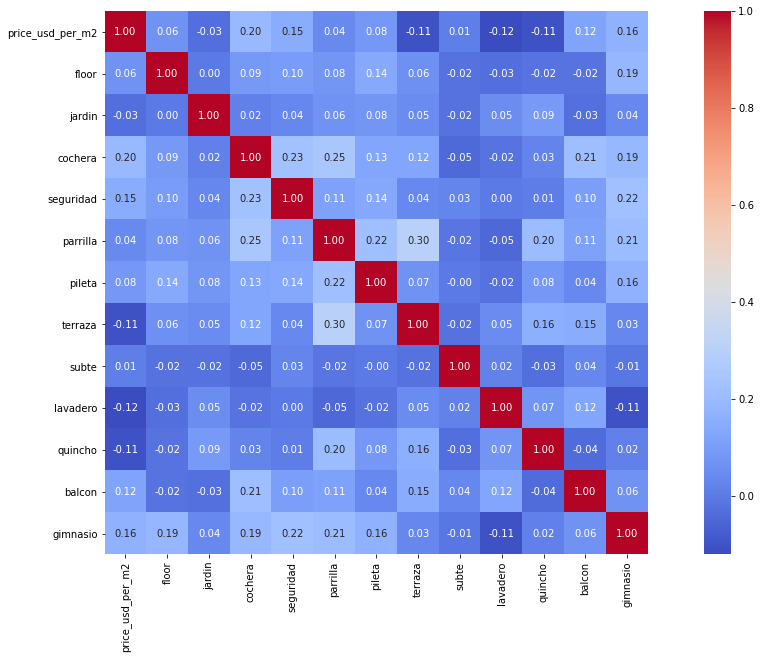

In [130]:
#Visualizaremos una matriz de correlacion.
fig= plt.figure(figsize=(20,10))
ax = plt.axes

corr = df_corr.corr()
ax = sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           cmap= 'coolwarm')
plt.show()


In [131]:
pd.get_dummies(df1[['jardin','cochera','seguridad',"parrilla",'pileta','terraza',
                  'subte','lavadero',"quincho", "balcon", "gimnasio"]], drop_first=True)

,jardin,cochera,seguridad,parrilla,pileta,terraza,subte,lavadero,quincho,balcon,gimnasio
0,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False
7,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
27174,False,False,False,False,False,False,False,False,False,True,False
27175,False,False,False,False,False,False,False,False,False,True,False
27176,False,False,False,True,False,True,False,True,False,False,False
27178,False,False,False,True,False,False,False,False,False,True,False


In [132]:
for i in lista_atributos:
    df1[i]=df1[i].replace([False,True],[str("sin" + i), str(i)])

In [133]:
df_dum = pd.get_dummies(df1[['jardin','cochera','seguridad',"parrilla",'pileta',
                                 'terraza','subte','lavadero',"quincho",
                                 "balcon", "gimnasio", "property_type","place_name"]],drop_first=True)
df_dum

,jardin_sinjardin,cochera_sincochera,seguridad_sinseguridad,parrilla_sinparrilla,pileta_sinpileta,terraza_terraza,subte_subte,lavadero_sinlavadero,quincho_sinquincho,balcon_sinbalcon,...,place_name_Villa Lugano,place_name_Villa Luro,place_name_Villa Ortuzar,place_name_Villa Pueyrredón,place_name_Villa Real,place_name_Villa Riachuelo,place_name_Villa Santa Rita,place_name_Villa Soldati,place_name_Villa Urquiza,place_name_Villa del Parque
0,1,1,1,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
7,1,1,1,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27174,1,1,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
27175,1,1,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
27176,1,1,1,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
27178,1,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
dfs = pd.concat([df1,df_dum],axis=1)
dfs= dfs.drop(["property_type","place_name","description","title","expenses","floor","price_per_m2",
              'jardin','cochera','seguridad',"parrilla",'pileta',
                                 'terraza','subte','lavadero',"quincho",
                                 "balcon", "gimnasio", "property_type","place_name"],axis=1)
dfs

,lat,lon,price_usd_per_m2,rooms,jardin_sinjardin,cochera_sincochera,seguridad_sinseguridad,parrilla_sinparrilla,pileta_sinpileta,terraza_terraza,...,place_name_Villa Lugano,place_name_Villa Luro,place_name_Villa Ortuzar,place_name_Villa Pueyrredón,place_name_Villa Real,place_name_Villa Riachuelo,place_name_Villa Santa Rita,place_name_Villa Soldati,place_name_Villa Urquiza,place_name_Villa del Parque
0,-34.661824,-58.508839,1127.272727,2.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-34.652262,-58.522982,1309.090909,2.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-34.559873,-58.443362,3066.666667,1.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-34.559873,-58.443362,3000.000000,2.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,-34.652356,-58.501624,1707.142857,4.0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27174,-34.629505,-58.460642,1666.666667,2.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
27175,-34.623443,-58.455030,2257.575758,1.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
27176,-34.599214,-58.402519,1813.186813,3.0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
27178,-34.587425,-58.397372,3750.000000,1.0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
from sklearn.preprocessing import MinMaxScaler
y=dfs.price_usd_per_m2
X= dfs.drop(["price_usd_per_m2"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler = StandardScaler()

columnas = ["lat","lon","rooms"]
for columna in columnas:
    X_train[[columna]] = scaler.fit_transform(X_train[[columna]])
    X_test[[columna]] = scaler.fit_transform(X_test[[columna]])
    
#CON LA TRAIN
#y_train = np.array(y_train)
#y_train= y_train.reshape(-1,1)
#y_train=scaler.fit_transform(y_train)
#CON LA TEST
#y_test = np.array(y_test)
#y_test= y_test.reshape(-1,1)
#y_test=scaler.fit_transform(y_test)

C:\Users\orest\AppData\Local\Temp\ipykernel_10344\196482908.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[[columna]] = scaler.fit_transform(X_train[[columna]])
C:\Users\orest\anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\orest\AppData\Local\Temp\ipykernel_10344\196482908.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

# Regresion Lineal Multiple


Para los datos de train:

R2 Ajustado: 0.455566419408458
R2:  0.45897383107273093
Mean Absolute Error (MAE): 384.6669551577716
Mean Squared Error (MSE):  263952.12711137434
Root Mean Squared Error (RMSE): 513.7627147929036 

Para los datos de test:

R2 Ajustado: 0.45401571758575643
R2:  0.45743283452844496
Mean Absolute Error (MAE): 386.8023359168325
Mean Squared Error (MSE):  269030.38482953387
Root Mean Squared Error (RMSE): 518.681390479294 



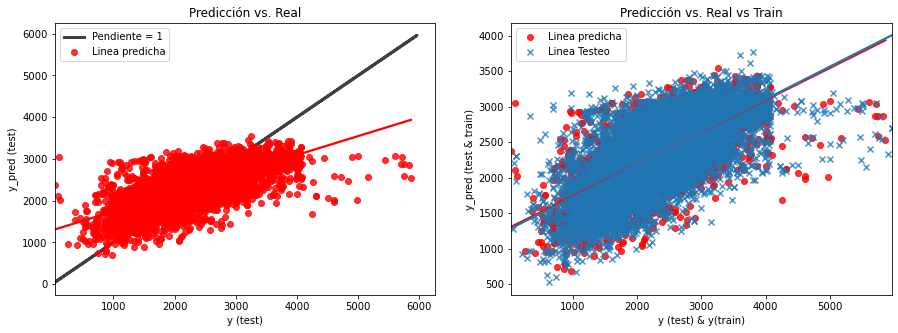

In [136]:
lr = linear_model.LinearRegression()
modelo_lrm = lr.fit(X_train,y_train)
evaluacion_modelos(modelo_lrm,X_train, X_test, y_train, y_test)

# LASSO

Para los datos de train:

R2 Ajustado: 0.4547743312787551
R2:  0.4581867003343949
Mean Absolute Error (MAE): 385.16606796700665
Mean Squared Error (MSE):  264336.1470435535
Root Mean Squared Error (RMSE): 514.1363117341095 

Para los datos de test:

R2 Ajustado: 0.4526191468536491
R2:  0.4560450044243448
Mean Absolute Error (MAE): 387.32208066467666
Mean Squared Error (MSE):  269718.5364368277
Root Mean Squared Error (RMSE): 519.3443332095072 

ALPHA: 0.1


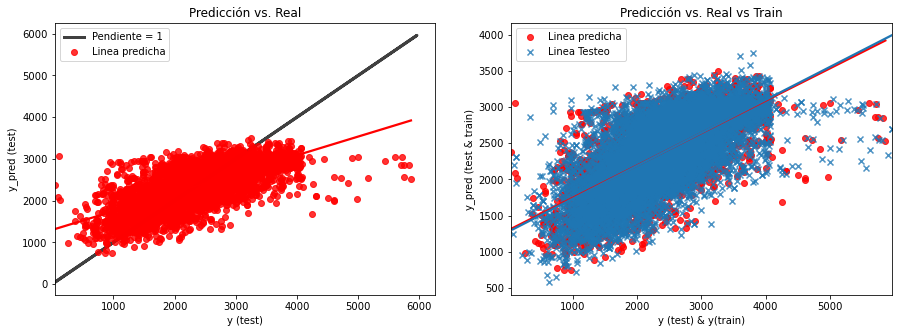

In [137]:
lr_lasso = linear_model.LassoCV(alphas = np.linspace(00000.1,00000.20,1000), normalize=False, cv=5)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
modelo_lassoCV = lr_lasso.fit(X_train, y_train)
evaluacion_modelos(modelo_lassoCV,X_train, X_test,y_train, y_test)
print(f"ALPHA: {modelo_lassoCV.alpha_}")

Para los datos de train:

R2 Ajustado: 0.4547743312787551
R2:  0.4581867003343949
Mean Absolute Error (MAE): 385.16606796700665
Mean Squared Error (MSE):  264336.1470435535
Root Mean Squared Error (RMSE): 514.1363117341095 

Para los datos de test:

R2 Ajustado: 0.4526191468536491
R2:  0.4560450044243448
Mean Absolute Error (MAE): 387.32208066467666
Mean Squared Error (MSE):  269718.5364368277
Root Mean Squared Error (RMSE): 519.3443332095072 



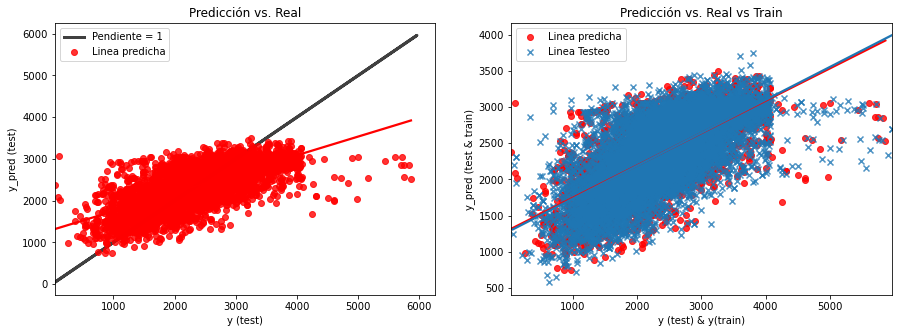

In [138]:
lasso = linear_model.Lasso(alpha=modelo_lassoCV.alpha_)
modelo_lasso = lr_lasso.fit(X_train, y_train)
evaluacion_modelos(modelo_lasso,X_train, X_test,y_train, y_test)
